## Human Activity Recognition with Decision Tree, SVM, and KNN
Aaron Katz, Vivian Perng, Mohammad Alkhawaldeh

In [428]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.feature_selection import mutual_info_classif

from scipy.stats import reciprocal, uniform

import random
import heapq



# Loading in Training Data
In this section, the training data was loaded in and organized into a readable format.

In [429]:
# Load training set data
X_train = pd.read_csv('train/X_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('train/y_train.txt', header=None)
subject_train = pd.read_csv('train/subject_train.txt', header=None)

# Load features and activity labels
features = pd.read_csv('features.txt', delim_whitespace=True, header=None, names=['Feature_Index', 'Feature_Name'])
activity_labels = pd.read_csv('activity_labels.txt', delim_whitespace=True, header=None, names=['Activity_Index', 'Activity_Name'])

# Set column names for X_train
X_train.columns = features['Feature_Name']

# Set column name for y_train
y_train.columns = ['Activity_Index']

# Set column name for subject_train
subject_train.columns = ['Subject_ID']

# Map activity labels to their corresponding names
y_train['Activity_Name'] = y_train['Activity_Index'].map(activity_labels.set_index('Activity_Index')['Activity_Name'])

# Combine features, labels, and subject IDs
combined_train_data = pd.concat([subject_train, y_train, X_train], axis=1)

# Display the combined data
combined_train_data.drop_duplicates()


,Subject_ID,Activity_Index,Activity_Name,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,1,5,STANDING,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,1,5,STANDING,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,1,5,STANDING,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,1,5,STANDING,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,1,5,STANDING,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,30,2,WALKING_UPSTAIRS,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,...,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819
7348,30,2,WALKING_UPSTAIRS,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,...,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053
7349,30,2,WALKING_UPSTAIRS,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,...,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811
7350,30,2,WALKING_UPSTAIRS,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,...,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339


In [430]:
x = combined_train_data.drop(columns=["Activity_Name"])
y = combined_train_data['Activity_Name']

# Exploratory Data Analysis
Initial exploration of the data and some of its features was conducted here. Additionally, this section also includes a trial of the SVM algorithm with features.

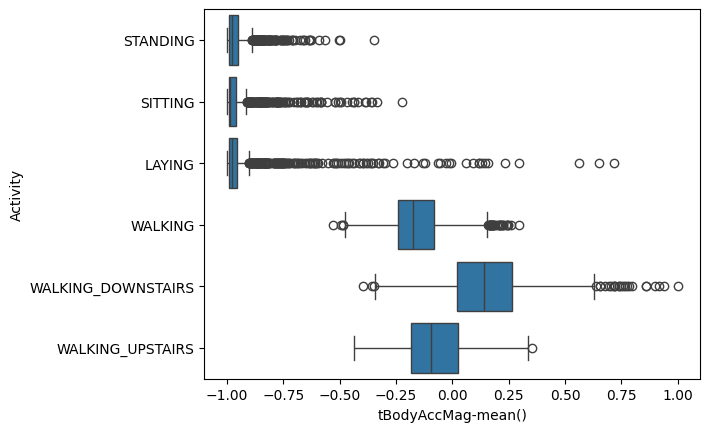

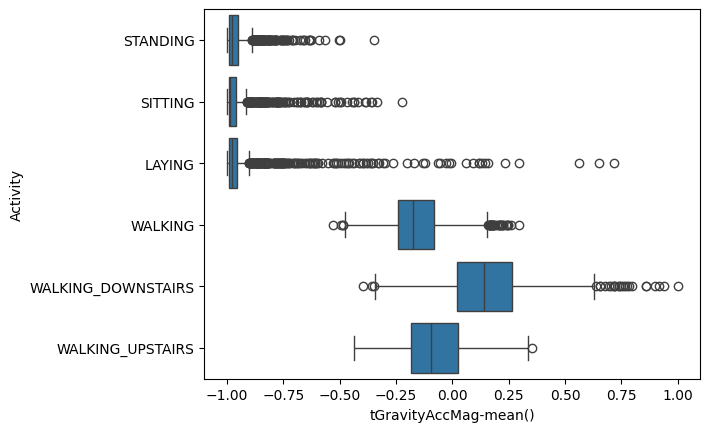

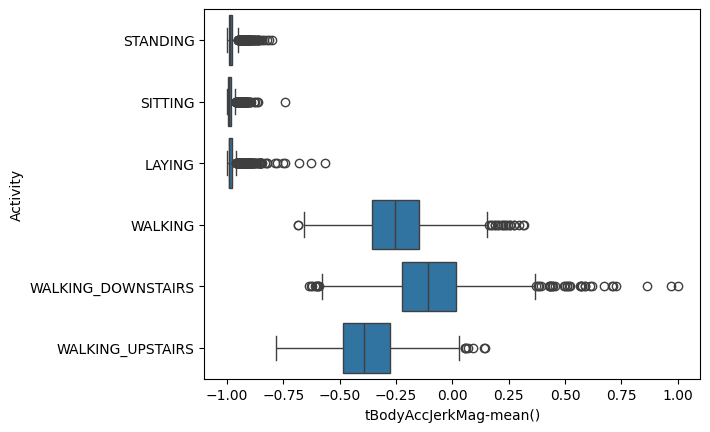

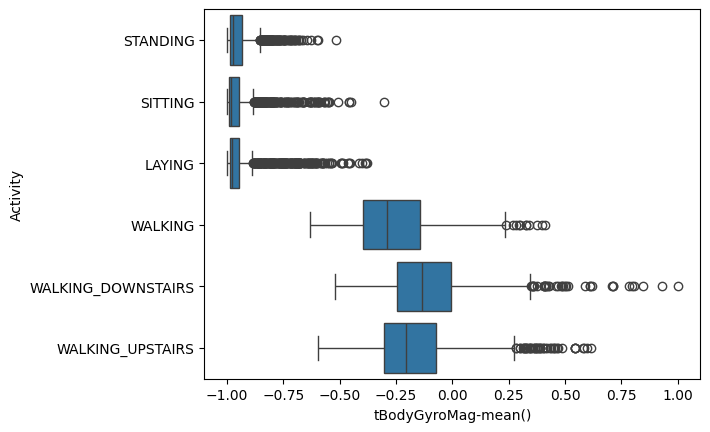

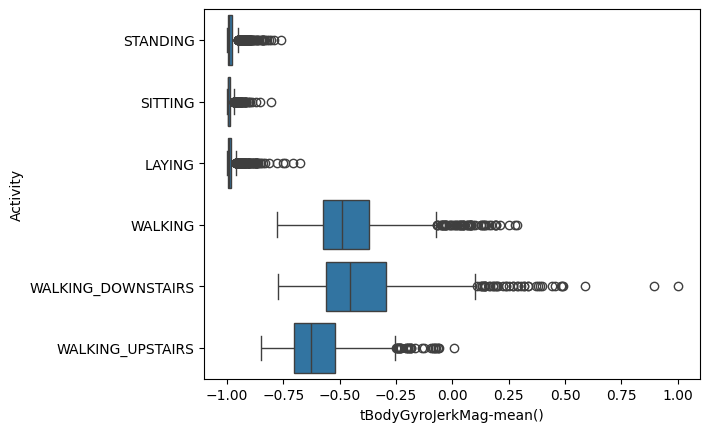

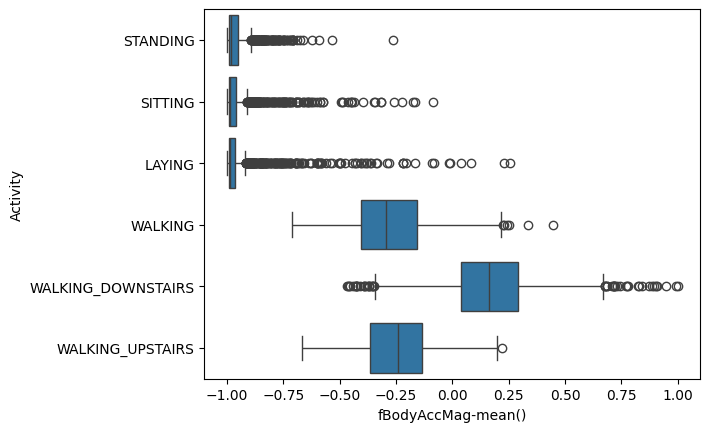

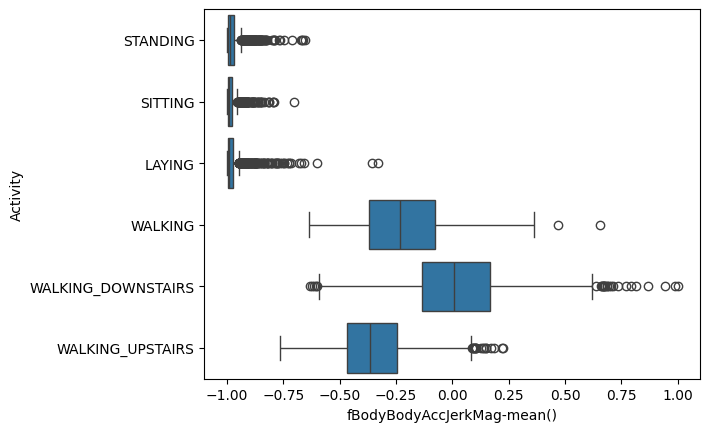

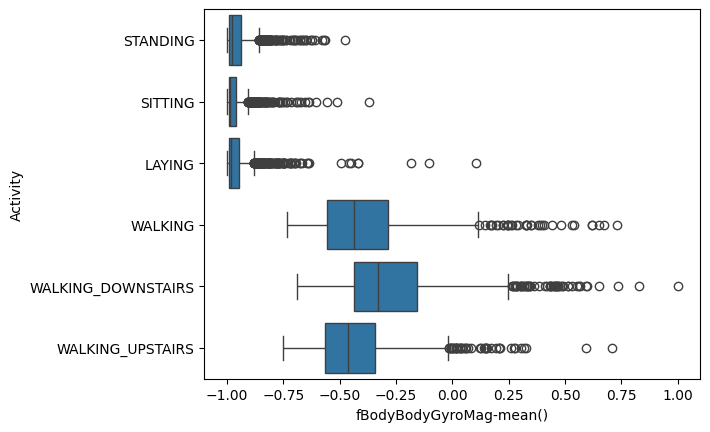

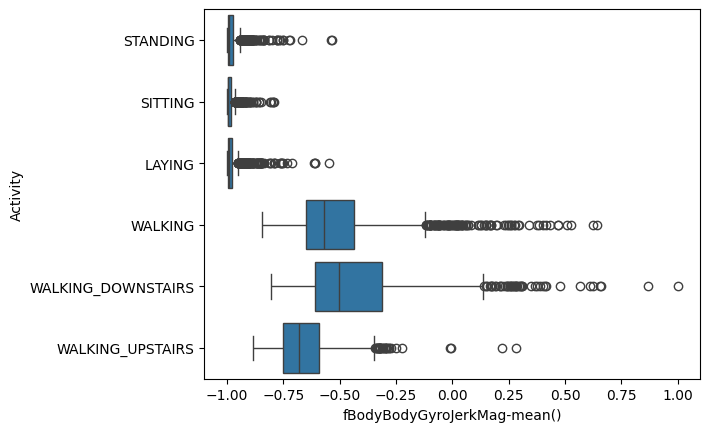

In [431]:
# Create boxplots of magnitude of 3-Dimensional signals and magnitude of frequency domain signals.
categories = ['tBodyAccMag-mean()', 'tGravityAccMag-mean()', 'tBodyAccJerkMag-mean()', 
              'tBodyGyroMag-mean()', 'tBodyGyroJerkMag-mean()', 'fBodyAccMag-mean()', 
              'fBodyBodyAccJerkMag-mean()', 'fBodyBodyGyroMag-mean()', 'fBodyBodyGyroJerkMag-mean()']
for i in categories:
    sns.boxplot(x=i, y='Activity_Name', data=combined_train_data, orient='h')
    plt.ylabel('Activity')
    plt.show()

In [432]:
# Find the mean of each feature grouped by the subject ID and activity name.
dfmean = combined_train_data.groupby(['Subject_ID', 'Activity_Name']).mean()

# Extract subset of columns in categories and assign to variable x
x = dfmean[categories]
print(x.head())

y = dfmean.reset_index()['Activity_Name']
print(y.head())


                               tBodyAccMag-mean()  tGravityAccMag-mean()  \
Subject_ID Activity_Name                                                   
1          LAYING                       -0.841929              -0.841929   
           SITTING                      -0.948537              -0.948537   
           STANDING                     -0.984278              -0.984278   
           WALKING                      -0.136971              -0.136971   
           WALKING_DOWNSTAIRS            0.027188               0.027188   

                               tBodyAccJerkMag-mean()  tBodyGyroMag-mean()  \
Subject_ID Activity_Name                                                     
1          LAYING                           -0.954396            -0.874760   
           SITTING                          -0.987364            -0.930892   
           STANDING                         -0.992368            -0.976494   
           WALKING                          -0.141429            -0.160980   

In [433]:
# Split x and y into training and testing sets with seed 0.
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

# Apply StandardScaler to x_train and x_test
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Create svm.SVC object and assign to variable svm.
svm = svm.SVC()

# Fit SVM on training data
svm.fit(x_train_scaled, y_train)

# Predict with input of testing data and assign the result to variable predictions1.
predictions1 = svm.predict(x_test_scaled)

# Calculate the accuracy_score on the y testing data and the test predictions and assign the result to the variable score1.
score1 = accuracy_score(y_test, predictions1)

# Print accuracy score. 
print('Accuracy score for Support Vector Machine:', score1)


Accuracy score for Support Vector Machine: 0.4375


# Feature Selection Search Algorithm
An algorithm to search for the best combination of features for each algorithm (Decision Tree, SVM, and KNN) was created.

In [434]:
from sklearn import svm
svm = svm.SVC()
max_heap = []

def setXandY():
  for i in range(9000):
    column_names = np.array(combined_train_data.columns)[3:]
    random.seed(i)
    selected_columns = random.sample(column_names.tolist(), k=random.randint(1, 9))
    x = dfmean[selected_columns]
    # Split x and y into training and testing sets with seed 0.
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

    # Apply StandardScaler to x_train and x_test
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Create svm.SVC object and assign to variable svm.
    

    # Fit SVM on training data
    svm.fit(x_train_scaled, y_train)
    # Predict with input of testing data and assign the result to variable predictions1.
    predictions1 = svm.predict(x_test_scaled)

    # Calculate the accuracy_score on the y testing data and the test predictions and assign the result to the variable score1.
    score1 = accuracy_score(y_test, predictions1)

    # Print accuracy score. 
    heapq.heappush(max_heap, [score1, selected_columns])
    # print(max_heap)
    # print('Accuracy score for Support Vector Machine:', score1)
  return heapq.nlargest(10, max_heap)

In [435]:
temp = setXandY()
for i in temp:
  print(i[0])
  print(i[1])


0.9375
['tBodyGyro-arCoeff()-X,1', 'tBodyAccJerkMag-mean()', 'tBodyAccJerk-correlation()-Y,Z', 'angle(X,gravityMean)', 'tGravityAcc-iqr()-Y', 'tBodyAcc-mean()-Y']
0.9375
['tBodyAcc-sma()', 'fBodyAcc-bandsEnergy()-1,8', 'fBodyAccJerk-bandsEnergy()-33,40', 'tBodyAcc-mean()-Y', 'tGravityAcc-min()-X', 'tGravityAcc-mean()-Y', 'tBodyAccJerk-arCoeff()-X,1']
0.9375
['fBodyAccJerk-skewness()-Y', 'fBodyAccJerk-std()-Z', 'tGravityAcc-mean()-Y', 'tGravityAccMag-mad()', 'fBodyAcc-std()-X', 'tBodyAccJerk-mean()-Y', 'tBodyGyroJerk-max()-Z']
0.90625
['tGravityAcc-mean()-Y', 'fBodyAcc-mad()-X', 'fBodyAcc-kurtosis()-X', 'fBodyAcc-mean()-Z', 'fBodyAcc-max()-Y', 'fBodyBodyAccJerkMag-kurtosis()', 'tGravityAcc-max()-X', 'fBodyBodyGyroJerkMag-max()', 'tBodyGyro-entropy()-Z']
0.90625
['tGravityAcc-arCoeff()-X,2', 'fBodyGyro-meanFreq()-X', 'tBodyAccJerkMag-max()', 'angle(X,gravityMean)', 'tGravityAcc-arCoeff()-Z,1', 'tBodyAcc-arCoeff()-Z,1', 'fBodyGyro-bandsEnergy()-1,8', 'tGravityAcc-std()-Y']
0.90625
['tBody

In [436]:
from sklearn import svm
svm = svm.SVC()
max_heap_one = []

results = []

def treeClassifier():
    for i in range(250):
    # Step 1: Randomly select subset of features
        column_names = np.array(combined_train_data.columns)[3:]
        random.seed(i)
        selected_columns = random.sample(column_names.tolist(), k=random.randint(1, 20))
        X = dfmean[selected_columns]
        
        # Step 2: Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Step 3: Define model and hyperparameters
        tree = DecisionTreeClassifier()
        param_grid = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
        
        # Step 4: Perform randomized search with cross-validation
        search = RandomizedSearchCV(tree, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=5)
        search.fit(X_train, y_train)
        
        # Step 5: Evaluate best model on test set
        best_model = search.best_estimator_
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        heapq.heappush(max_heap_one, [accuracy, selected_columns])
        
    return heapq.nlargest(10, max_heap_one)

In [437]:
temp = treeClassifier()
for i in temp:
  print(i[0])
  print(i[1])

1.0
['tBodyAcc-arCoeff()-Y,2', 'fBodyGyro-bandsEnergy()-1,24', 'tBodyGyroJerk-iqr()-Z', 'fBodyGyro-bandsEnergy()-25,48', 'tBodyAcc-mean()-Y', 'fBodyAcc-max()-Y', 'tBodyAcc-min()-X', 'fBodyAccJerk-mad()-Y', 'fBodyAccJerk-bandsEnergy()-1,24', 'tBodyGyroMag-sma()', 'fBodyAcc-max()-X', 'fBodyBodyAccJerkMag-kurtosis()', 'fBodyAccJerk-min()-X', 'fBodyGyro-bandsEnergy()-57,64', 'angle(tBodyGyroMean,gravityMean)', 'tBodyGyroJerk-arCoeff()-Y,1', 'tBodyGyroJerk-mean()-Y']
0.8846153846153846
['fBodyGyro-mad()-Y', 'tGravityAcc-mean()-Y', 'fBodyAcc-mean()-X', 'fBodyBodyAccJerkMag-entropy()', 'fBodyGyro-bandsEnergy()-17,32', 'fBodyAccJerk-bandsEnergy()-41,48', 'fBodyAcc-bandsEnergy()-1,16', 'fBodyGyro-bandsEnergy()-1,8', 'fBodyAccJerk-entropy()-X', 'tGravityAccMag-arCoeff()2', 'fBodyBodyAccJerkMag-std()', 'tBodyGyro-entropy()-X', 'fBodyAcc-entropy()-Y']
0.8846153846153846
['fBodyGyro-energy()-X', 'fBodyAccJerk-kurtosis()-Z', 'tGravityAcc-min()-X', 'tBodyAcc-entropy()-X', 'tGravityAcc-mean()-Z', 'tBo

In [438]:
max_heap = []

def knn_feature_selection():
  for i in range(3000):
    column_names = np.array(combined_train_data.columns)[3:]
    random.seed(i)
    selected_columns = random.sample(column_names.tolist(), k=random.randint(1,20))
    x = dfmean[selected_columns]
    
    # Split x and y into training and testing sets with seed 0.
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

    # Apply StandardScaler to x_train and x_test
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Calculate the optimal number of neighbors based on your training data size
    n_neighbors = int(np.sqrt(len(x_train_scaled)))
    
    # Instantiate the KNN model with the calculated number of neighbors
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Fit the KNN model to your scaled training data
    knn.fit(x_train_scaled, y_train)
    
    # Use the fitted model to make predictions on your test data
    knn_predictions = knn.predict(x_test_scaled)

    # Evaluate the KNN model's performance
    knn_score = accuracy_score(y_test, knn_predictions)
    
    # Print accuracy score. 
    heapq.heappush(max_heap, [knn_score, selected_columns])
    # print(max_heap)
    # print('Accuracy score for Support Vector Machine:', score1)
  return heapq.nlargest(10, max_heap)

knn_feature_results = knn_feature_selection()
for i in knn_feature_results:
  print(i[0])
  print(i[1])

0.9375
['tGravityAccMag-std()', 'tBodyGyroJerkMag-sma()', 'fBodyGyro-bandsEnergy()-33,40', 'tBodyAccMag-mean()', 'fBodyAccJerk-bandsEnergy()-1,16', 'tBodyAcc-mad()-X', 'angle(X,gravityMean)', 'tGravityAcc-arCoeff()-Z,1', 'tGravityAcc-std()-Y', 'tBodyAccJerkMag-max()', 'fBodyBodyAccJerkMag-meanFreq()', 'tBodyGyro-entropy()-X', 'fBodyAccJerk-mad()-X']
0.9375
['tBodyGyroJerk-std()-X', 'fBodyAcc-bandsEnergy()-33,48', 'tBodyAcc-mean()-Y', 'fBodyGyro-bandsEnergy()-9,16', 'fBodyAcc-bandsEnergy()-1,24', 'tBodyAccMag-arCoeff()2', 'tBodyAccJerk-min()-X', 'tBodyGyroJerk-mad()-Z', 'fBodyGyro-mad()-Y', 'fBodyGyro-bandsEnergy()-49,56', 'tBodyAccJerk-arCoeff()-X,4', 'fBodyAccJerk-bandsEnergy()-1,24', 'tGravityAcc-arCoeff()-X,1', 'angle(Y,gravityMean)', 'fBodyGyro-maxInds-Z', 'fBodyAcc-energy()-Z', 'tGravityAcc-min()-X', 'fBodyAcc-entropy()-Y', 'fBodyAcc-mad()-X', 'tBodyAcc-mean()-X']
0.9375
['tBodyGyro-arCoeff()-X,1', 'tBodyAccJerkMag-mean()', 'tBodyAccJerk-correlation()-Y,Z', 'angle(X,gravityMean)',

# Decision Tree Algorithm - Training Data
The Decision Tree Algorithm was run on the training data with the best combination of features found in the feature selection algorithm.

In [439]:
# List of features to be used in Decision Tree
tree_features = ['tBodyAcc-arCoeff()-Y,2', 'fBodyGyro-bandsEnergy()-1,24', 
                 'tBodyGyroJerk-iqr()-Z', 'fBodyGyro-bandsEnergy()-25,48', 
                 'tBodyAcc-mean()-Y', 'fBodyAcc-max()-Y', 'tBodyAcc-min()-X', 
                 'fBodyAccJerk-mad()-Y', 'fBodyAccJerk-bandsEnergy()-1,24', 
                 'tBodyGyroMag-sma()', 'fBodyAcc-max()-X', 'fBodyBodyAccJerkMag-kurtosis()', 
                 'fBodyAccJerk-min()-X', 'fBodyGyro-bandsEnergy()-57,64', 
                 'angle(tBodyGyroMean,gravityMean)', 'tBodyGyroJerk-arCoeff()-Y,1', 
                 'tBodyGyroJerk-mean()-Y']

# Extract subset of columns in tree_features and assign to variable x_tree
x_tree = dfmean[tree_features]

# Step 2: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x_tree, y, test_size=0.2, random_state=42)

# Step 3: Define model and hyperparameters
tree = DecisionTreeClassifier()
param_grid = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}

# Step 4: Perform randomized search with cross-validation
search = RandomizedSearchCV(tree, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=5)
search.fit(X_train, y_train)

# Step 5: Evaluate best model on test set
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score for Decision Tree:", accuracy)

Accuracy score for Decision Tree: 0.9230769230769231


# Support Vector Machine - Training Data
The SVM was run on the training data with the best combination of features found in the feature selection algorithm. Then, some performance metrics and analysis was conducted to better understand the results.

In [441]:
from sklearn import svm
# List of features to be used in SVM
svm_features = ['tBodyGyro-arCoeff()-X,1', 'tBodyAccJerkMag-mean()', 
                'tBodyAccJerk-correlation()-Y,Z', 'angle(X,gravityMean)',
                'tGravityAcc-iqr()-Y', 'tBodyAcc-mean()-Y']

# Extract subset of columns in svm_features and assign to variable x_svm
x_svm = dfmean[svm_features]

# Split x and y into training and testing sets with seed 0.
x_train, x_test, y_train, y_test = train_test_split(x_svm, y, random_state=0)

# Apply StandardScaler to x_train and x_test
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Create svm.SVC object and assign to variable svm.
svm = svm.SVC()

# Fit SVM on training data
svm.fit(x_train_scaled, y_train)

# Predict with input of testing data and assign the result to variable predictions1.
predictions1 = svm.predict(x_test_scaled)

# Calculate the accuracy_score on the y testing data and the test predictions and assign the result to the variable score1.
score1 = accuracy_score(y_test, predictions1)

# Print accuracy score. 
print('Accuracy score for Support Vector Machine:', score1)

# # Define the parameter grid
# param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}

# # Create a RandomizedSearchCV instance
# rnd_search_cv = RandomizedSearchCV(svm, param_distributions, n_iter=10, verbose=2, cv=3)
# rnd_search_cv.fit(x_train_scaled, y_train)

# # Get the best parameters and the best score
# print("Best parameters: ", rnd_search_cv.best_params_)
# print("Best score: ", rnd_search_cv.best_score_)

# # Use the best estimator to make predictions
# best_svm = rnd_search_cv.best_estimator_
# predictions2 = best_svm.predict(x_test_scaled)

# # Calculate the accuracy score
# score1 = accuracy_score(y_test, predictions2)
# print('Accuracy score for Support Vector Machine after hyperparameter tuning:', score1)

Accuracy score for Support Vector Machine: 0.9375


Classification Report for SVM Classifier:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00         6
           SITTING       0.83      1.00      0.91         5
          STANDING       1.00      0.89      0.94         9
           WALKING       1.00      1.00      1.00         5
WALKING_DOWNSTAIRS       1.00      0.83      0.91         6
  WALKING_UPSTAIRS       0.50      1.00      0.67         1

          accuracy                           0.94        32
         macro avg       0.89      0.95      0.90        32
      weighted avg       0.96      0.94      0.94        32

Confusion Matrix for SVM Classifier:
                     LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
LAYING                   6        0         0        0                   0   
SITTING                  0        5         0        0                   0   
STANDING                 0        1         8        0                   0   
WALK

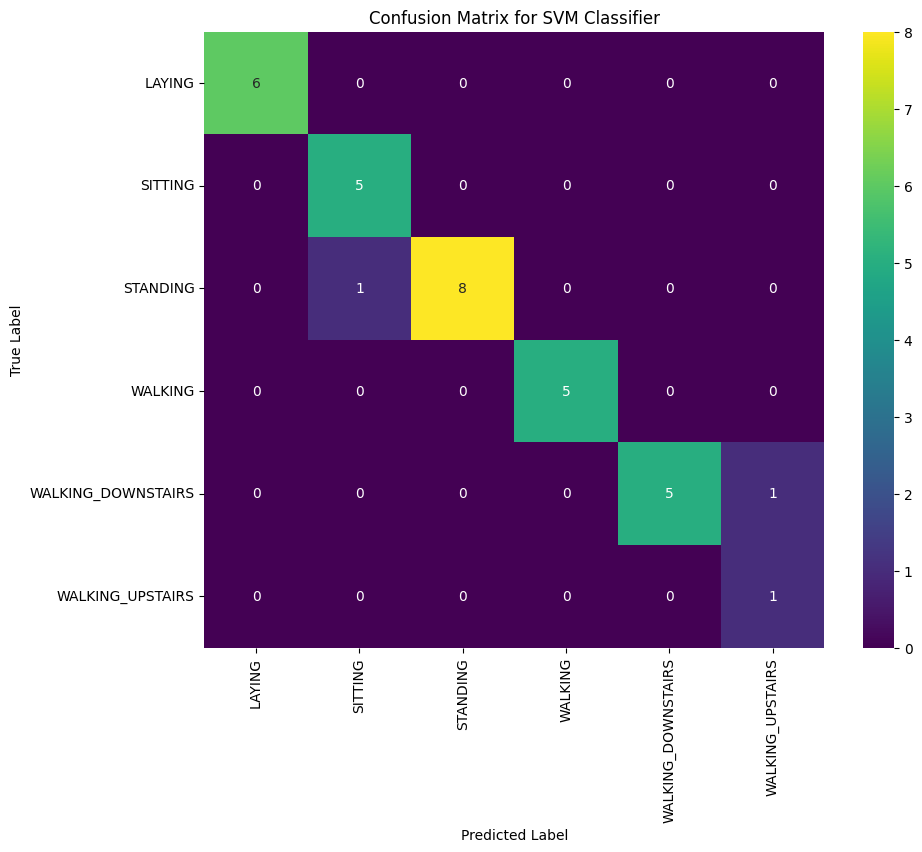

In [442]:
# Create classification report for results of SVM
class_report = classification_report(y_test, predictions1)
print("Classification Report for SVM Classifier:\n", class_report)

# Create confusion matrix for results of SVM classifier
conf_matrix = confusion_matrix(y_test, predictions1)
conf_matrix_df = pd.DataFrame(conf_matrix, index=np.unique(y_test), columns=np.unique(y_test))
print("Confusion Matrix for SVM Classifier:\n", conf_matrix_df)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix for SVM Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



# K-Nearest Neighbors - Training Data
The KNN Algorithm was run on the training data with the best combination of features found in the feature selection algorithm. Then, some performance metrics and analysis was conducted to better understand the results.

In [443]:
# List of features to be used in KNN
knn_features = ['tBodyGyro-arCoeff()-X,1', 'tBodyAccJerkMag-mean()', 
                'tBodyAccJerk-correlation()-Y,Z', 'angle(X,gravityMean)',
                'tGravityAcc-iqr()-Y', 'tBodyAcc-mean()-Y',
                'fBodyAcc-bandsEnergy()-33,48', 'tBodyAccMag-max()', 
                'fBodyAccJerk-bandsEnergy()-41,48', 'fBodyAcc-bandsEnergy()-57,64',
                'tBodyGyro-mad()-Z', 'fBodyBodyGyroMag-energy()']

# Extract subset of columns in knn_features and assign to variable x_knn
x_knn = dfmean[knn_features]

# Split x and y into training and testing sets with seed 0.
x_train, x_test, y_train, y_test = train_test_split(x_knn, y, random_state=0)

# Apply StandardScaler to x_train and x_test
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Calculate the optimal number of neighbors based on your training data size
n_neighbors = int(np.sqrt(len(x_train_scaled)))

# Instantiate the KNN model with the calculated number of neighbors
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Fit the KNN model to your scaled training data
knn.fit(x_train_scaled, y_train)

# Use the fitted model to make predictions on your test data
knn_predictions = knn.predict(x_test_scaled)

# Evaluate the KNN model's performance
knn_score = accuracy_score(y_test, knn_predictions)
print('Accuracy score for K-Nearest Neighbors:', knn_score)

# For a more detailed performance analysis, consider using a confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_test, knn_predictions))
print("Classification Report:\n", classification_report(y_test, knn_predictions))

# Perform grid search to find optimal hyperparameters
param_grid = {'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Accuracy score for K-Nearest Neighbors: 0.9375
Confusion Matrix:
 [[6 0 0 0 0 0]
 [0 5 0 0 0 0]
 [0 1 8 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 5 1]
 [0 0 0 0 0 1]]
Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00         6
           SITTING       0.83      1.00      0.91         5
          STANDING       1.00      0.89      0.94         9
           WALKING       1.00      1.00      1.00         5
WALKING_DOWNSTAIRS       1.00      0.83      0.91         6
  WALKING_UPSTAIRS       0.50      1.00      0.67         1

          accuracy                           0.94        32
         macro avg       0.89      0.95      0.90        32
      weighted avg       0.96      0.94      0.94        32

Best parameters: {'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.915204678362573


In [444]:
# Initialize KNN classifier with an initial value of k
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_scaled, y_train)
initial_predictions = knn.predict(x_test_scaled)

# Evaluate initial accuracy
print(f'Initial Accuracy score for K-Nearest Neighbors: {accuracy_score(y_test, initial_predictions):.4f}')

Initial Accuracy score for K-Nearest Neighbors: 0.9062


In [445]:
# Perform grid search to find optimal hyperparameters
param_grid = {'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_scaled, y_train)

# Print best parameters found
print(f"Best parameters from Grid Search: {grid_search.best_params_}")
print(f"Best cross-validation score from Grid Search: {grid_search.best_score_:.4f}")

Best parameters from Grid Search: {'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score from Grid Search: 0.9152


In [446]:
# Cross-validate the best estimator from grid search
best_knn = grid_search.best_estimator_
cv_scores = cross_val_score(best_knn, x_train_scaled, y_train, cv=5)

# Print cross-validation scores
print("Cross-Validation Scores for the best KNN model:", [f'{score:.4f}' for score in cv_scores])
print(f"Mean CV Score for the best KNN model: {np.mean(cv_scores):.4f}")

Cross-Validation Scores for the best KNN model: ['0.8421', '0.9474', '0.8947', '0.9474', '0.9444']
Mean CV Score for the best KNN model: 0.9152


In [447]:
# Fit the best estimator on the training data and evaluate on the test data
best_knn.fit(x_train_scaled, y_train)
final_predictions = best_knn.predict(x_test_scaled)

# Print final accuracy
print(f'Final Accuracy score for K-Nearest Neighbors: {accuracy_score(y_test, final_predictions):.4f}')

Final Accuracy score for K-Nearest Neighbors: 0.9062


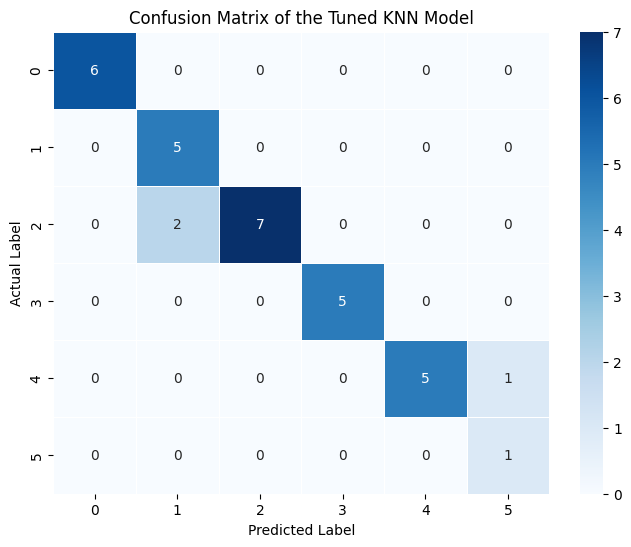

0: 'Laying',
1: 'Sitting',
2: 'Standing',
3: 'Walking',
4: 'Walking Downstairs',
5: 'Walking Upstairs'



In [448]:
# Display Confusion Matrix of the final model
cm_final = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt="d", linewidths=.5, cmap='Blues')
plt.title('Confusion Matrix of the Tuned KNN Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print('''\
0: 'Laying',
1: 'Sitting',
2: 'Standing',
3: 'Walking',
4: 'Walking Downstairs',
5: 'Walking Upstairs'
''')


In [449]:
# Display Classification Report of the final model
print("Final Classification Report for K-Nearest Neighbors:")
print(classification_report(y_test, final_predictions))

Final Classification Report for K-Nearest Neighbors:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00         6
           SITTING       0.71      1.00      0.83         5
          STANDING       1.00      0.78      0.88         9
           WALKING       1.00      1.00      1.00         5
WALKING_DOWNSTAIRS       1.00      0.83      0.91         6
  WALKING_UPSTAIRS       0.50      1.00      0.67         1

          accuracy                           0.91        32
         macro avg       0.87      0.94      0.88        32
      weighted avg       0.94      0.91      0.91        32



In [450]:
# Calculate and display Performance Metrics of the final model
precision_final, recall_final, f1_score_final, _ = precision_recall_fscore_support(y_test, final_predictions, average=None, labels=np.unique(y_test))
metrics_df_final = pd.DataFrame({'Precision': precision_final, 'Recall': recall_final, 'F1-score': f1_score_final}, index=np.unique(y_test))
print("Performance Metrics of the Tuned KNN Model:\n", metrics_df_final.round(4))

Performance Metrics of the Tuned KNN Model:
                     Precision  Recall  F1-score
LAYING                 1.0000  1.0000    1.0000
SITTING                0.7143  1.0000    0.8333
STANDING               1.0000  0.7778    0.8750
WALKING                1.0000  1.0000    1.0000
WALKING_DOWNSTAIRS     1.0000  0.8333    0.9091
WALKING_UPSTAIRS       0.5000  1.0000    0.6667


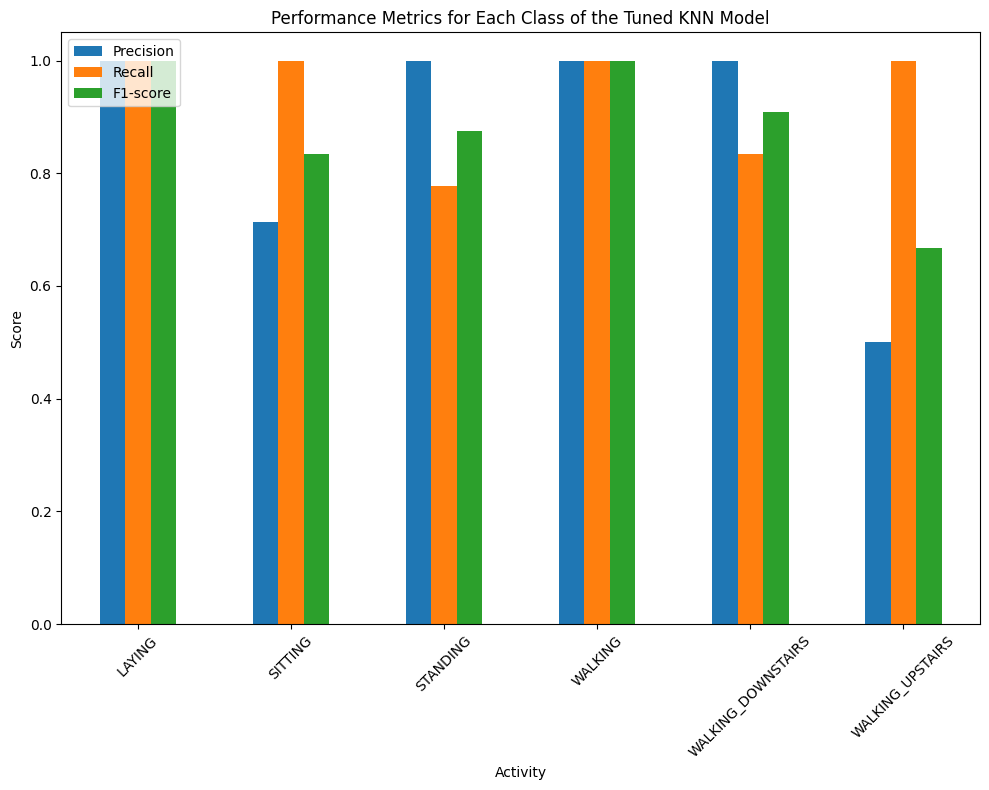

In [451]:
# Plotting performance metrics of the final model
fig, ax = plt.subplots(figsize=(10, 8))
metrics_df_final.plot(kind='bar', ax=ax)
plt.title('Performance Metrics for Each Class of the Tuned KNN Model')
plt.xlabel('Activity')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

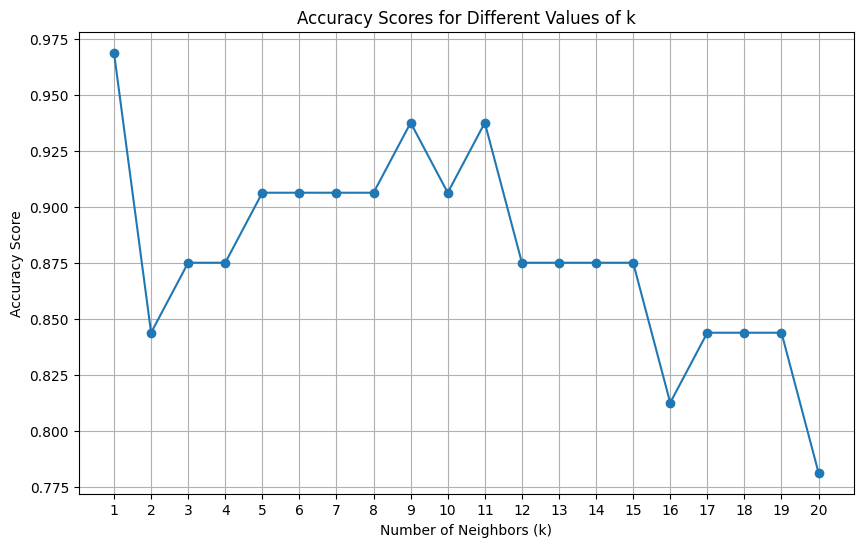

In [452]:
# Initialize lists to store accuracy scores for different values of k
k_values = range(1, 21)
accuracy_scores = []

# Loop through different values of k
for k in k_values:
    # Initialize KNN classifier with current value of k
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_scaled, y_train)  # Train the model
    knn_predictions = knn.predict(x_test_scaled)  # Predict on test data
    accuracy_scores.append(accuracy_score(y_test, knn_predictions))  # Append accuracy score to the list

# Plot accuracy scores against different values of k
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o')
plt.title('Accuracy Scores for Different Values of k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()





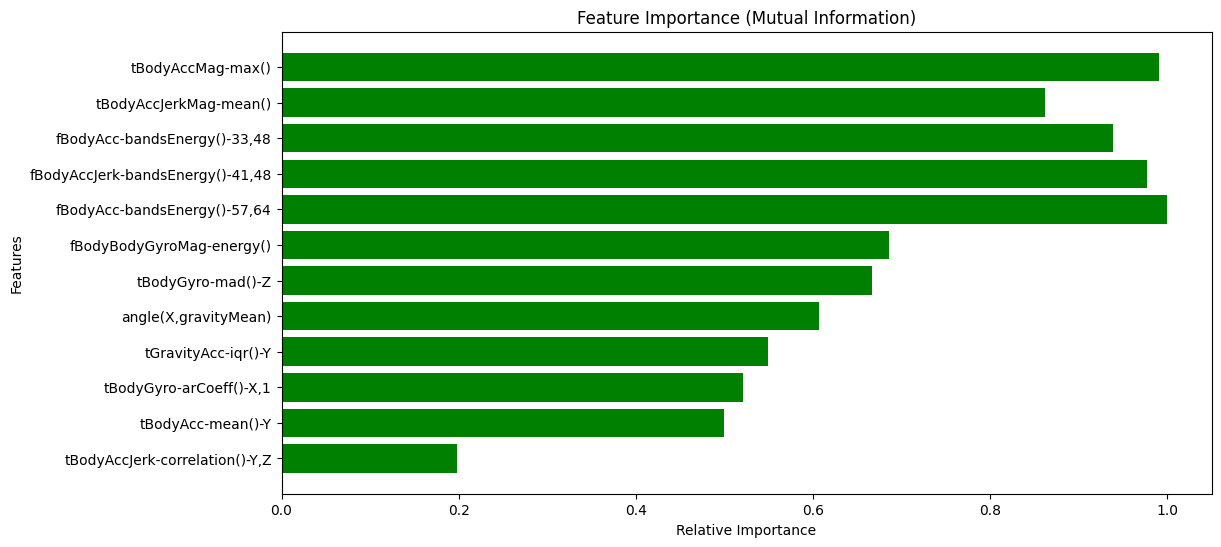

In [453]:
# Calculate Mutual Information between each feature and the target
# This uses the scaled training data (x_train_scaled) and the corresponding labels (y_train)
mi = mutual_info_classif(x_train_scaled, y_train)

# Normalize the mutual information scores to create a relative scale of importance
mi /= np.max(mi)

# Extract the feature names from the DataFrame to use in plotting
# This assumes that 'x_train' was created from a DataFrame and has column names
feature_names = x_train.columns

# Sorting the features based on their mutual information scores for better visualization
sorted_idx = np.argsort(mi)

# Creating a bar chart to visualize the features and their importance scores
plt.figure(figsize=(12, 6))
plt.barh(feature_names[sorted_idx], mi[sorted_idx], color='green')
plt.title('Feature Importance (Mutual Information)')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()


# Loading in Test Data
In this section, the test data was loaded in and organized so that it is in a readable format.

In [454]:
# Load test set data
x_test = pd.read_csv('test/X_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv('test/y_test.txt', header=None)
subject_test = pd.read_csv('test/subject_test.txt', header=None)

# Load features and activity labels
features = pd.read_csv('features.txt', delim_whitespace=True, header=None, names=['Feature_Index', 'Feature_Name'])
activity_labels = pd.read_csv('activity_labels.txt', delim_whitespace=True, header=None, names=['Activity_Index', 'Activity_Name'])

# Set column names for x_test
x_test.columns = features['Feature_Name']

# Set column name for y_test
y_test.columns = ['Activity_Index']

# Set column name for subject_test
subject_test.columns = ['Subject_ID']

# Map activity labels to their corresponding names
y_test['Activity_Name'] = y_test['Activity_Index'].map(activity_labels.set_index('Activity_Index')['Activity_Name'])

# Combine features, labels, and subject IDs
combined_test_data = pd.concat([subject_test, y_test, x_test], axis=1)

# Display the combined data
combined_test_data.drop_duplicates()

x = combined_test_data.drop(columns=["Activity_Name"])

y = combined_test_data['Activity_Name']

# Find the mean of each feature grouped by the subject ID and activity name.
dfmean = combined_test_data.groupby(['Subject_ID', 'Activity_Name']).mean()
y = dfmean.reset_index()['Activity_Name']


# Performance of KNN Algorithm on Test Data
The KNN algorithm was chosen to predict human activity on the final test data. Performance metrics and analysis on the results of the KNN algorithm on the test data was conducted in this section.

In [455]:
# List of features to be used in KNN
knn_features = ['tBodyGyro-arCoeff()-X,1', 'tBodyAccJerkMag-mean()', 
                'tBodyAccJerk-correlation()-Y,Z', 'angle(X,gravityMean)',
                'tGravityAcc-iqr()-Y', 'tBodyAcc-mean()-Y',
                'fBodyAcc-bandsEnergy()-33,48', 'tBodyAccMag-max()', 
                'fBodyAccJerk-bandsEnergy()-41,48', 'fBodyAcc-bandsEnergy()-57,64',
                'tBodyGyro-mad()-Z', 'fBodyBodyGyroMag-energy()']

# Extract subset of columns in knn_features and assign to variable x_knn
x_knn = dfmean[knn_features]

# Apply StandardScaler to x_train and x_test
scaler = StandardScaler()
scaler.fit(x_knn)
x_test_scaled = scaler.transform(x_knn)

# Calculate the optimal number of neighbors based on your training data size
n_neighbors = int(np.sqrt(len(x_test_scaled)))

# Instantiate the KNN model with the calculated number of neighbors
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Fit the KNN model to your scaled training data
knn.fit(x_test_scaled, y)

# Use the fitted model to make predictions on your test data
knn_predictions = knn.predict(x_test_scaled)

# Evaluate the KNN model's performance
knn_score = accuracy_score(y, knn_predictions)
print(f'Accuracy score for K-Nearest Neighbors: {knn_score:.4f}')

# For a more detailed performance analysis, consider using a confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y, knn_predictions))
print("Classification Report:\n", classification_report(y, knn_predictions))

Accuracy score for K-Nearest Neighbors: 0.8889
Confusion Matrix:
 [[9 0 0 0 0 0]
 [0 7 2 0 0 0]
 [0 0 9 0 0 0]
 [0 0 0 9 0 0]
 [0 0 0 3 6 0]
 [0 0 0 0 1 8]]
Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00         9
           SITTING       1.00      0.78      0.88         9
          STANDING       0.82      1.00      0.90         9
           WALKING       0.75      1.00      0.86         9
WALKING_DOWNSTAIRS       0.86      0.67      0.75         9
  WALKING_UPSTAIRS       1.00      0.89      0.94         9

          accuracy                           0.89        54
         macro avg       0.90      0.89      0.89        54
      weighted avg       0.90      0.89      0.89        54



Accuracy for k=1: 0.7273
Accuracy for k=2: 0.6364
Accuracy for k=3: 0.7273
Accuracy for k=4: 0.7273
Accuracy for k=5: 0.7273
Accuracy for k=6: 0.7273
Accuracy for k=7: 0.8182
Accuracy for k=8: 0.8182
Accuracy for k=9: 0.7273
Accuracy for k=10: 0.8182
Accuracy for k=11: 0.7273
Accuracy for k=12: 0.7273
Accuracy for k=13: 0.6364
Accuracy for k=14: 0.6364
Accuracy for k=15: 0.7273
Accuracy for k=16: 0.7273
Accuracy for k=17: 0.6364
Accuracy for k=18: 0.5455
Accuracy for k=19: 0.5455
Accuracy for k=20: 0.3636


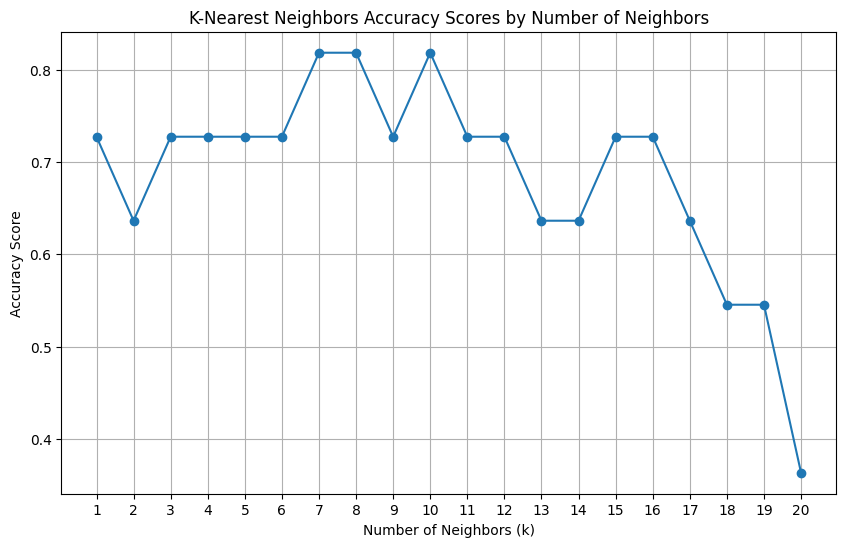

In [456]:
# Extract the specified features from dfmean
x_knn = dfmean[knn_features]

# Prepare your data by splitting and scaling
X_train, X_test, y_train, y_test = train_test_split(x_knn, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize lists to store accuracy scores for different values of k
k_values = range(1, 21)  # Testing k from 1 to 20
accuracy_scores = []

# Loop through different values of k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)  # Train the model
    predictions = knn.predict(X_test_scaled)  # Predict on test data
    score = accuracy_score(y_test, predictions)  # Calculate accuracy
    accuracy_scores.append(score)  # Store the accuracy score

    print(f'Accuracy for k={k}: {score:.4f}')  # Optional: Print accuracy for each k

# Plot accuracy scores against different values of k
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o')
plt.title('K-Nearest Neighbors Accuracy Scores by Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

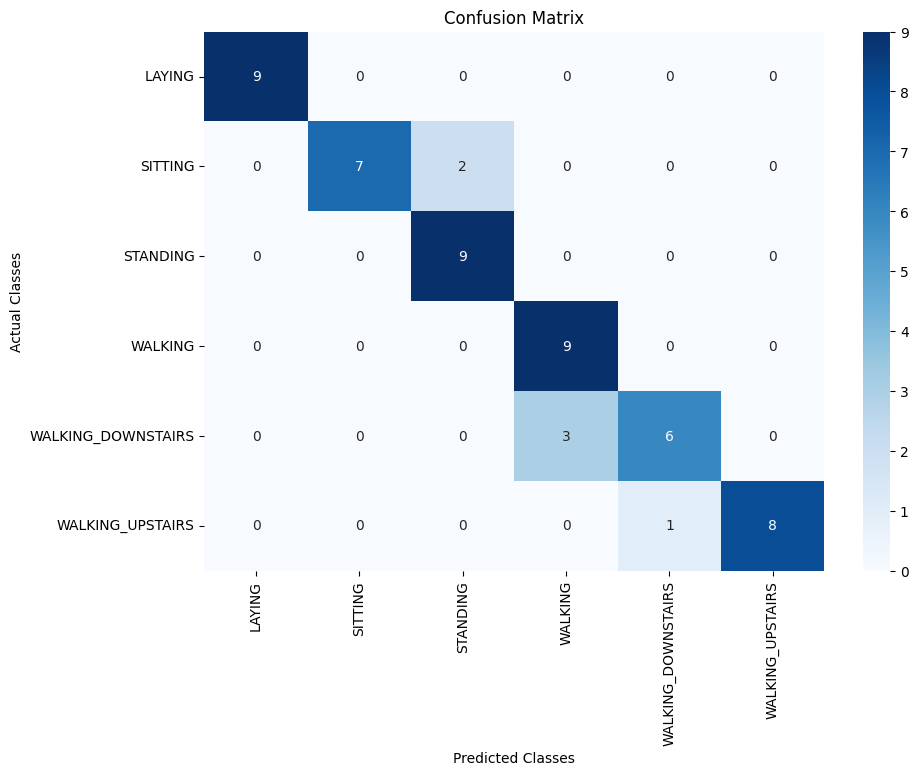

In [457]:
# Generate the confusion matrix
cm = confusion_matrix(y, knn_predictions)
class_names = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']  # class names as per your dataset

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()